In [65]:
import scanpy as sc
import numpy as np
import pandas as pd
from scSLAT.viz.multi_dataset import  *

In [66]:
class match_3D_keypoints(match_3D_multi):
    r"""
    """
    def __init__(self,dataset_A: pd.DataFrame,
                dataset_B: pd.DataFrame,
                matching: np.ndarray,
                highlight_celltype: Optional[List[List[str]]]=[[],[]],
                highlight_line: Optional[Union[List[str],str]]='red',
                highlight_cell: Optional[str]=None,
                meta: Optional[str]=None,
                expr: Optional[str]=None,
                subsample_size: Optional[int]=300,
                reliability: Optional[np.ndarray]=None,
                scale_coordinate: Optional[bool]=False,
                rotate: Optional[List[str]]=None,
                exchange_xy: Optional[bool]=False,
                subset: Optional[Union[np.ndarray,List[int]]]=None
        ) -> None:
        super().__init__(dataset_A,dataset_B,matching,meta,expr,subsample_size,
                                                reliability,scale_coordinate,rotate,exchange_xy,subset)
        assert set(highlight_celltype[0]).issubset(set(self.celltypes))
        assert set(highlight_celltype[1]).issubset(set(self.celltypes))
        self.highlight_celltype = highlight_celltype
        self.highlight_line = highlight_line
        self.highlight_cell = highlight_cell
        
    
    def draw_3D(self,
                size: Optional[List[int]]=[10,10],
                conf_cutoff: Optional[float]=0,
                point_size: Optional[List[int]]=[0.1,0.1],
                line_width: Optional[float]=0.3,
                line_color:Optional[str]='grey',
                line_alpha: Optional[float]=0.7,
                hide_axis: Optional[bool]=False,
                show_error: Optional[bool]=True,
                show_celltype: Optional[bool]=False,
                cmap: Optional[bool]='Reds',
                save:Optional[str]=None
        ) -> None:
        self.conf_cutoff = conf_cutoff
        show_error = show_error if self.meta else False
        fig = plt.figure(figsize=(size[0],size[1]))
        ax = fig.add_subplot(111, projection='3d')       
        
        # color by meta
        if self.meta:
            color = ['red', 'grey', 'red']
            c_map = {}
            for i, celltype in enumerate(self.celltypes):
                c_map[celltype] = color[i]
            if self.expr:
                c_map = cmap
                # expr_concat = pd.concat(self.datasets)[self.expr].to_numpy()
                # norm = plt.Normalize(expr_concat.min(), expr_concat.max())
            for i, dataset in enumerate(self.datasets):
                for cell_type in self.celltypes:
                    
                    size = 10 if cell_type not in ['Unlabel'] else point_size[i]
                    alpha = 1 if cell_type not in ['Unlabel'] else 0.6
                    slice = dataset[dataset[self.meta] == cell_type]
                    xs = slice['x']
                    ys = slice['y']
                    zs = i
                    ax.scatter(xs, ys, zs, s=size, c=c_map[cell_type], alpha=alpha)
        # plot points without meta
        else:
            for i, dataset in enumerate(self.datasets):
                xs = dataset['x']
                ys = dataset['y']
                zs = i
                ax.scatter(xs,ys,zs,s=point_size[i])
        # plot line
        self.c_map = c_map
        self.draw_lines(ax, show_error, show_celltype, line_color, line_width, line_alpha)
        if hide_axis:
            plt.axis('off')
        if save != None:
            plt.savefig(save)
        plt.show()
        
        
    def draw_lines(self, ax, show_error, show_celltype, default_color, line_width:float=0.3, line_alpha:float=0.7)-> None:
        
        for i in range(self.matching.shape[1]):
            pair = self.matching[:,i]
            a = self.dataset_A.loc[self.dataset_A['index']==pair[1], self.meta].astype(str).values
            b = self.dataset_B.loc[self.dataset_B['index']==pair[0], self.meta].astype(str).values
            point0 = np.append(self.dataset_A[self.dataset_A['index']==pair[1]][['x','y']], 0)
            point1 = np.append(self.dataset_B[self.dataset_B['index']==pair[0]][['x','y']], 1)
            coord = np.row_stack((point0, point1))

            if b in self.highlight_celltype[1]:
                # target cell
                ax.scatter(point0[0],point0[1],point0[2],color='blue',alpha=1,s=10)
                ax.plot(coord[:,0], coord[:,1], coord[:,2], color='grey', linestyle="dashed",
                        linewidth=line_width, alpha=line_alpha)
                
    def draw_ground_truth(self, ax, index_list):
        pass

In [36]:
adata1 = sc.read_h5ad('../../case/spatial_cross_platform/seqFISH_filter.h5ad')
adata2 = sc.read_h5ad('../../case/spatial_cross_platform/Stereo_filter.h5ad')

In [37]:
key_points1 = pd.read_csv('./keypoints/seqFISH_meta_labeled.csv', index_col=0)
key_points2 = pd.read_csv('./keypoints/stereo_meta_labeled.csv', index_col=0)
adata1.obs['key_points'] = key_points1['key_points']
adata2.obs['key_points'] = key_points2['key_points']

In [52]:
adata1.obs['key_points'].value_counts()

Unlabel                   11522
keypiont_Shapes_shapes        7
Name: key_points, dtype: int64

In [38]:
adata1_df = pd.DataFrame({'index':range(adata1.shape[0]),
                          'x': adata1.obsm['spatial'][:,0],
                          'y': adata1.obsm['spatial'][:,1],
                          'celltype':adata1.obs['key_points']})
adata2_df = pd.DataFrame({'index':range(adata2.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'celltype':adata2.obs['key_points']})

In [39]:
slat_matching = np.loadtxt('../results/stereo_seqfish_embryo_9.5/cells:0/seed:0/SLAT_dpca/matching.csv', dtype=int)

In [40]:
slat_matching

array([[    0,     1,     2, ...,  5028,  5029,  5030],
       [ 9935, 10993, 10993, ...,    64,   115,    84]])

In [69]:
def plot_matching(adata1_df, adata2_df, matching):
    multi_align = match_3D_keypoints(adata1_df, adata2_df, matching, meta='celltype', 
                                highlight_celltype = [['keypiont_Shapes_shapes'],['Shapes_shapes']],
                                subsample_size=10000, highlight_line = 'blue',
                                scale_coordinate=True, exchange_xy=False)
    multi_align.draw_3D(size=[7, 8], line_width=1.2, line_color='grey', point_size=[0.1, 0.1], 
                        hide_axis=True, show_error=False)

SLAT_dpca
dataset1: 2 cell types; dataset2: 2 cell types; 
                    Total :3 celltypes; Overlap: 1 cell types 
                    Not overlap :[['keypiont_Shapes_shapes', 'Shapes_shapes']]
Subsampled 5031 pairs from 5031


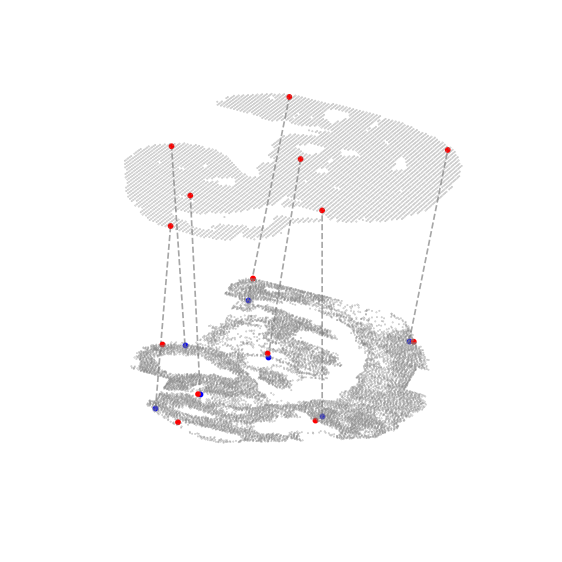

PASTE
dataset1: 2 cell types; dataset2: 2 cell types; 
                    Total :3 celltypes; Overlap: 1 cell types 
                    Not overlap :[['keypiont_Shapes_shapes', 'Shapes_shapes']]
Subsampled 5031 pairs from 5031


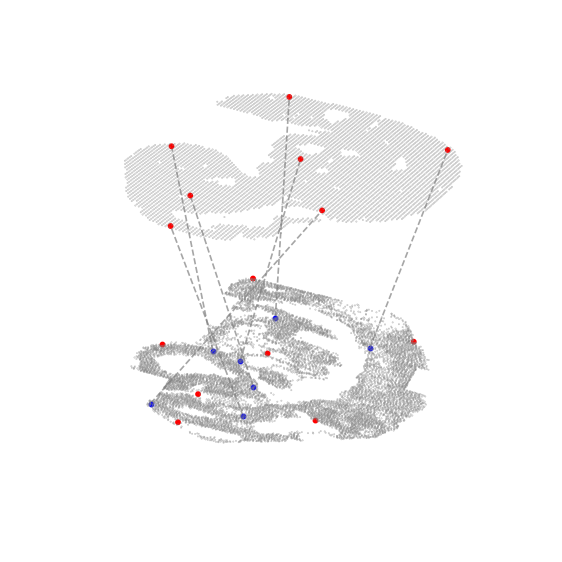

STAGATE
dataset1: 2 cell types; dataset2: 2 cell types; 
                    Total :3 celltypes; Overlap: 1 cell types 
                    Not overlap :[['keypiont_Shapes_shapes', 'Shapes_shapes']]
Subsampled 5031 pairs from 5031


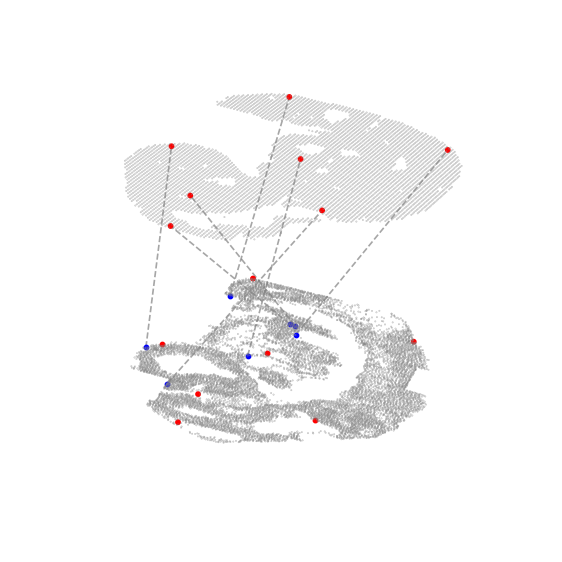

Seurat
dataset1: 2 cell types; dataset2: 2 cell types; 
                    Total :3 celltypes; Overlap: 1 cell types 
                    Not overlap :[['keypiont_Shapes_shapes', 'Shapes_shapes']]
Subsampled 5031 pairs from 5031


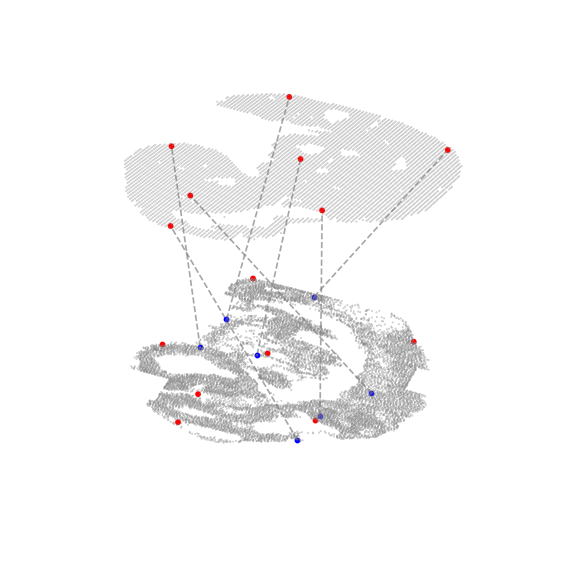

Harmony
dataset1: 2 cell types; dataset2: 2 cell types; 
                    Total :3 celltypes; Overlap: 1 cell types 
                    Not overlap :[['keypiont_Shapes_shapes', 'Shapes_shapes']]
Subsampled 5031 pairs from 5031


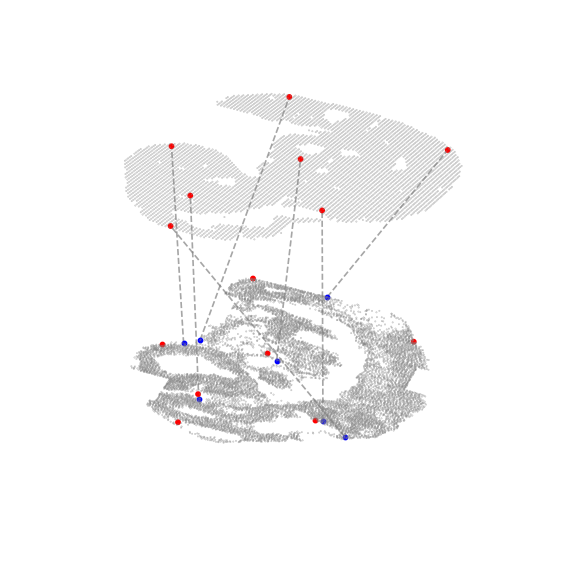

In [71]:
for method in ['SLAT_dpca', 'PASTE', 'STAGATE', 'Seurat', 'Harmony']:
    print(method)
    matching = np.loadtxt(f'../results/stereo_seqfish_embryo_9.5/cells:0/seed:0/{method}/matching.csv', dtype=int)
    plot_matching(adata1_df, adata2_df, matching)